In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import findlay2025a as f25a
import wisc_ecephys_tools as wet

/home/gfindlay/projects/ece/gfys_workspace/.venv/lib/python3.13/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [8]:
save_plots = False

In [2]:
nbsh = wet.get_sglx_project("seahorse")
experiment = wet.rats.constants.SleepDeprivationExperiments.NOD
sortings = f25a.units.get_nod_sortings()

In [3]:
frs = pd.read_parquet(nbsh.get_project_file("firing_rates_by_condition.pqt"))
cond_fr_cols = [c for c in frs.columns if c not in ["subject", "cluster_id"]]

In [4]:
cell_types = pd.read_parquet(nbsh.get_project_file("cell_types.pqt"))
cluster_quality = pd.read_parquet(nbsh.get_project_file("cluster_quality.pqt"))
mps_metrics = pd.read_parquet(nbsh.get_project_file("mps_metrics.pqt"))
state_fr_cols = [c for c in mps_metrics.columns if "firing_rate_" in c]

id_cols = ["subject", "experiment", "probe", "cluster_id"]
df = pd.merge(cell_types, cluster_quality, on=id_cols, how="left")
df = pd.merge(df, mps_metrics, on=id_cols, how="left")
df = pd.merge(df, frs, on=["subject", "cluster_id"], how="left")

In [5]:
df = df.drop(columns=["firing_rate"], errors="ignore")
df = pd.melt(
    df,
    id_vars=[col for col in df.columns if col not in cond_fr_cols + state_fr_cols],
    value_vars=cond_fr_cols + state_fr_cols,
    var_name="condition",
    value_name="firing_rate",
)
df["condition"] = df["condition"].str.replace("firing_rate_", "", regex=False)


In [6]:
strictness = "sua_moderate"
strictness_levels = ["mua", "sua_permissive", "sua_moderate", "sua_conservative"]
strictness_index = strictness_levels.index(strictness)
df = df.loc[df["max_quality"].isin(strictness_levels[strictness_index:])]

In [7]:
paired_palette = sns.color_palette("Paired")
for i in np.arange(len(paired_palette))[1::2]:  # Desaturate some colors a bit
    paired_palette[i] = tuple(
        (np.array(paired_palette[i]) + np.array(paired_palette[i - 1])) / 2
    )

ext_condition_palette = {
    k: v
    for k, v in zip(
        [
            "early_bsl_nrem",
            "early_rec_nrem_match",
            "early_ext_wake",
            "late_ext_wake",
            "early_rec_nrem",
            "late_rec_nrem",
        ],
        paired_palette,
    )
}  # Assign colors to conditions

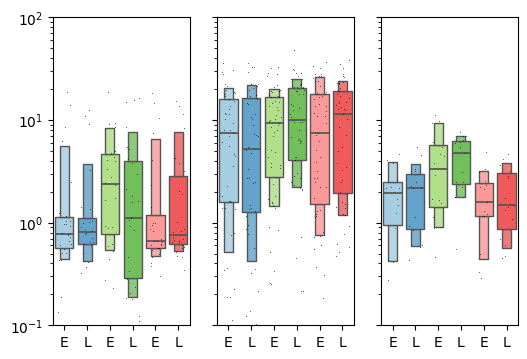

In [16]:
var = "firing_rate"
region = "hippocampal"
petersen_cell_types = ["pyramidal", "narrow interneuron", "wide interneuron"]
n_cols = len(petersen_cell_types)
fig, axes = plt.subplots(1, n_cols, figsize=(2 * n_cols, 4), sharey=True)
for petersen_cell_type, ax in zip(petersen_cell_types, axes):
    _df = df.loc[
        df["condition"].isin(ext_condition_palette.keys())
        & (df["region"] == region)
        & (df["petersen_cell_type"] == petersen_cell_type)
        & (df["firing_rate"] > 0.1),
        ["subject", "cluster_id", "condition", var],
    ]
    g = sns.boxenplot(
        data=_df,
        x="condition",
        y=var,
        saturation=1.0,
        linewidth=1.0,
        showfliers=False,
        order=ext_condition_palette.keys(),
        ax=ax,
        hue="condition",
        palette=ext_condition_palette,
        log_scale=True,
        k_depth=2,
    )
    sns.stripplot(
        data=_df,
        x="condition",
        y=var,
        color="k",
        s=0.5,
        jitter=0.3,
        ax=ax,
        order=ext_condition_palette.keys(),
    )
    ax.set_xticks(range(len(ext_condition_palette)))
    ax.set_xticklabels(["E", "L", "E", "L", "E", "L"])
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_ylim(0.1, 100)
    # ax.set_title(petersen_cell_type)

if save_plots:
    fig.savefig(
        nbsh.get_project_file(f"figures/hc_frs.ext_wake.restricted.{strictness}.png"),
        bbox_inches="tight",
        dpi=600,
    )

In [10]:
strictness = "sua_moderate"
df = pd.read_parquet(nbsh.get_project_file(f"estm_on_frs.with_meta.{strictness}.pqt"))

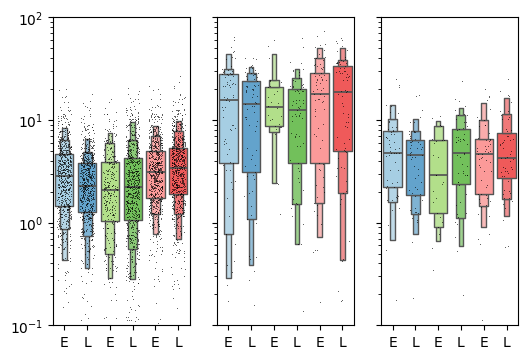

In [17]:
var = "on_firing_rate"
region = "cortical"
petersen_cell_types = ["pyramidal", "narrow interneuron", "wide interneuron"]
n_cols = len(petersen_cell_types)
fig, axes = plt.subplots(1, n_cols, figsize=(2 * n_cols, 4), sharey=True)
for petersen_cell_type, ax in zip(petersen_cell_types, axes):
    _df = df.loc[
        df["condition"].isin(ext_condition_palette.keys())
        & (df["region"] == region)
        & (df["petersen_cell_type"] == petersen_cell_type),
        ["subject", "cluster_id", "condition", var],
    ]
    g = sns.boxenplot(
        data=_df,
        x="condition",
        y=var,
        saturation=1.0,
        linewidth=1.0,
        showfliers=False,
        order=ext_condition_palette.keys(),
        ax=ax,
        hue="condition",
        palette=ext_condition_palette,
        log_scale=True,
        k_depth=3,
    )
    sns.stripplot(
        data=_df,
        x="condition",
        y=var,
        color="k",
        s=0.5,
        jitter=0.3,
        ax=ax,
        order=ext_condition_palette.keys(),
    )
    ax.set_xticks(range(len(ext_condition_palette)))
    ax.set_xticklabels(["E", "L", "E", "L", "E", "L"])
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_ylim(0.1, 100)
    # ax.set_title(petersen_cell_type)

if save_plots:
    fig.savefig(
        nbsh.get_project_file(
            f"figures/cx_on_frs.ext_wake.restricted.{strictness}.png"
        ),
        bbox_inches="tight",
        dpi=600,
    )